# Agrupamento hierárquico - Parte 2

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [4]:
# Carregando pacotes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from gower import gower_matrix
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [5]:
df = pd.read_csv('shoppers_intention.csv')

In [6]:
df.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [7]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [9]:
df.ExitRates.value_counts()

ExitRates
0.200000    710
0.100000    338
0.050000    329
0.033333    291
0.066667    267
           ... 
0.021816      1
0.015787      1
0.010302      1
0.014534      1
0.029031      1
Name: count, Length: 4777, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [11]:
# Verificando as variáveis categóricas 

df.select_dtypes('object').describe().transpose()

count unique                top   freq
Month        12330     10                May   3364
VisitorType  12330      3  Returning_Visitor  10551

In [12]:
df.Month.unique() # Não há acessos relacionados aos meses de Janeiro e Abril

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [13]:
df.VisitorType.unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [14]:
# Verificando as variáveis numéricas

df.select_dtypes('number').describe().T

count         mean          std  min         25%  \
Administrative           12330.0     2.315166     3.321784  0.0    0.000000   
Administrative_Duration  12330.0    80.818611   176.779107  0.0    0.000000   
Informational            12330.0     0.503569     1.270156  0.0    0.000000   
Informational_Duration   12330.0    34.472398   140.749294  0.0    0.000000   
ProductRelated           12330.0    31.731468    44.475503  0.0    7.000000   
ProductRelated_Duration  12330.0  1194.746220  1913.669288  0.0  184.137500   
BounceRates              12330.0     0.022191     0.048488  0.0    0.000000   
ExitRates                12330.0     0.043073     0.048597  0.0    0.014286   
PageValues               12330.0     5.889258    18.568437  0.0    0.000000   
SpecialDay               12330.0     0.061427     0.198917  0.0    0.000000   
OperatingSystems         12330.0     2.124006     0.911325  1.0    2.000000   
Browser                  12330.0     2.357097     1.717277  1.0    2.000000   
Region                   12330.0     3.147364     2.401591  1.0    1.000000   
TrafficType              12330.0     4.069586     4.025169  1.0    2.000000   

                                50%          75%           max  
Administrative             1.000000     4.000000     27.000000  
Administrative_Duration    7.500000    93.256250   3398.750000  
Informational              0.000000     0.000000     24.000000  
Informational_Duration     0.000000     0.000000   2549.375000  
ProductRelated            18.000000    38.000000    705.000000  
ProductRelated_Duration  598.936905  1464.157214  63973.522230  
BounceRates                0.003112     0.016813      0.200000  
ExitRates                  0.025156     0.050000      0.200000  
PageValues                 0.000000     0.000000    361.763742  
SpecialDay                 0.000000     0.000000      1.000000  
OperatingSystems           2.000000     3.000000      8.000000  
Browser                    2.000000     2.000000     13.000000  
Region                     3.000000     4.000000      9.000000  
TrafficType                2.000000     4.000000     20.000000

##### Verificando a distribuição das variáveis

In [16]:
vars = df.columns

for var in vars:
    print(f'Para a variável {var}, os valores únicos são:')
    print(df[var].unique())
    print('\n')

Para a variável Administrative, os valores únicos são:
[ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26]


Para a variável Administrative_Duration, os valores únicos são:
[  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]


Para a variável Informational, os valores únicos são:
[ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]


Para a variável Informational_Duration, os valores únicos são:
[  0.   120.    16.   ... 547.75 368.25 211.25]


Para a variável ProductRelated, os valores únicos são:
[  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29  34  71  63
  87  40  33  54  64  75  39 111  81  61  47  44  88 149  41  79  66  43
 258  80  62  83 173  48  58  57  56  69  82  59 109 287  53  84  78 137
 113  89  65  60 104 129  77  74  93  76  72 194 140 110 132 115  73 328
 16

##### As variáveis abaixo são relevantes?

- `'OperatingSystems', 'Browser', 'Region', 'TrafficType',  'VisitorType'`

Vejamos... Mas vale lembrar que elas não fornecem muita informação para o estudo em questão.

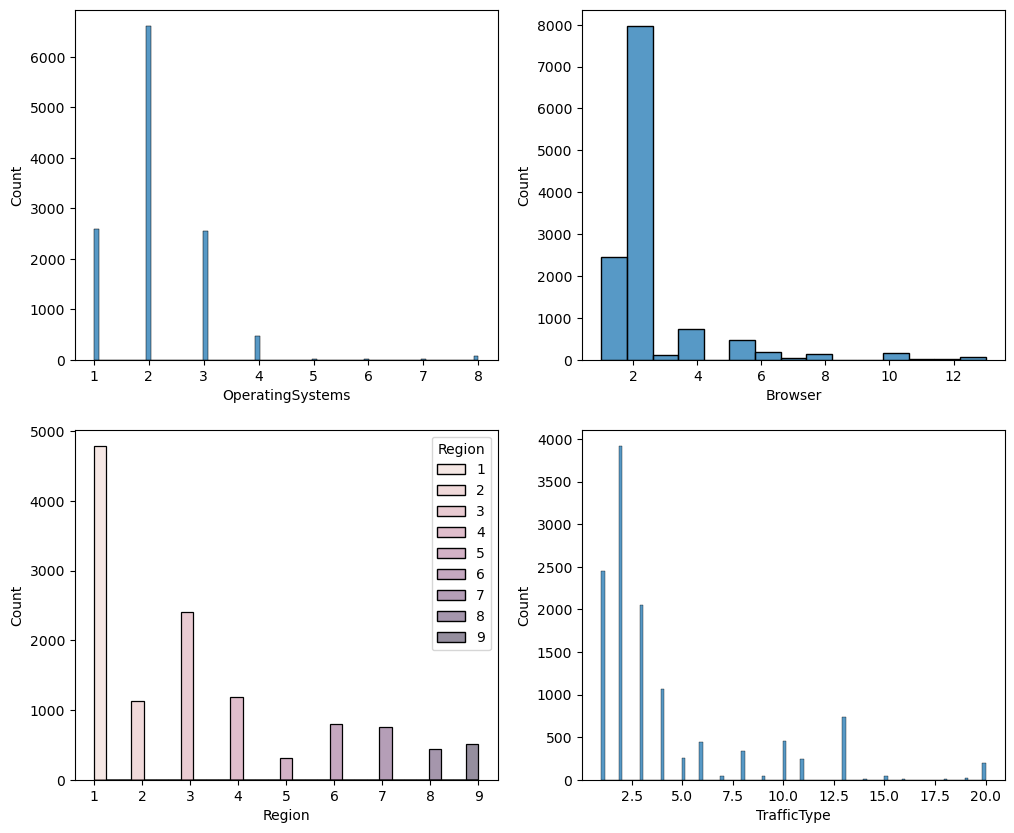

In [18]:
vars = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

fig, ax = plt.subplots(2, 2, figsize=[12,10])

sns.histplot(df, x=vars[0], ax=ax[0,0])
sns.histplot(df, x=vars[1], ax=ax[0,1])
sns.histplot(df, x=vars[2], hue=vars[2], ax=ax[1,0])
sns.histplot(df, x=vars[3], ax=ax[1,1])
plt.show()

A utilização de tais variáveis poderá depender do objetivo do estudo. Não são relevantes para nosso caso.

##### Varificando a existência de dados faltantes

In [21]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Não há dados faltantes no conjunto de dados.

##### Avaliando a necessidade de padronização dos dados

In [24]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [25]:
df2 = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
          'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
          'SpecialDay', 'Month', 'VisitorType', 'Weekend', 'Revenue']]
print(df2.shape)
df2.head()

(12330, 14)


Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month        VisitorType  \
0         0.20       0.20         0.0         0.0   Feb  Returning_Visitor   
1         0.00       0.10         0.0         0.0   Feb  Returning_Visitor   
2         0.20       0.20         0.0         0.0   Feb  Returning_Visitor   
3         0.05       0.14         0.0         0.0   Feb  Returning_Visitor   
4         0.02       0.05         0.0         0.0   Feb  Returning_Visitor   

   Weekend  Revenue  
0    False    False  
1    False    False  
2    False    False  
3    False    False  
4     True    False

In [26]:
# Vamos analisar a matriz de covariância para entender a discrepância dos dados 
df_num = df2.select_dtypes('number')

df_num.cov()

Administrative  Administrative_Duration  \
Administrative                11.034250               353.262991   
Administrative_Duration      353.262991             31250.852838   
Informational                  1.590002                67.969566   
Informational_Duration       119.618925              5922.571332   
ProductRelated                63.692718              2272.897243   
ProductRelated_Duration     2377.054106            120238.091288   
BounceRates                   -0.036009                -1.235789   
ExitRates                     -0.051089                -1.767978   
PageValues                     6.105711               221.925626   
SpecialDay                    -0.062625                -2.577683   

                         Informational  Informational_Duration  \
Administrative                1.590002              119.618925   
Administrative_Duration      67.969566             5922.571332   
Informational                 1.613297              110.652802   
Informational_Duration      110.652802            19810.363880   
ProductRelated               21.136857             1753.060431   
ProductRelated_Duration     941.893393            93561.546616   
BounceRates                  -0.007151               -0.505482   
ExitRates                    -0.010102               -0.720078   
PageValues                    1.146970               80.654719   
SpecialDay                   -0.012183               -0.856066   

                         ProductRelated  ProductRelated_Duration  BounceRates  \
Administrative                63.692718             2.377054e+03    -0.036009   
Administrative_Duration     2272.897243             1.202381e+05    -1.235789   
Informational                 21.136857             9.418934e+02    -0.007151   
Informational_Duration      1753.060431             9.356155e+04    -0.505482   
ProductRelated              1978.070394             7.327469e+04    -0.441180   
ProductRelated_Duration    73274.692403             3.662130e+06   -17.123683   
BounceRates                   -0.441180            -1.712368e+01     0.002351   
ExitRates                     -0.632253            -2.343394e+01     0.002151   
PageValues                    46.479789             1.877007e+03    -0.107489   
SpecialDay                    -0.211957            -1.384842e+01     0.000701   

                         ExitRates   PageValues  SpecialDay  
Administrative           -0.051089     6.105711   -0.062625  
Administrative_Duration  -1.767978   221.925626   -2.577683  
Informational            -0.010102     1.146970   -0.012183  
Informational_Duration   -0.720078    80.654719   -0.856066  
ProductRelated           -0.632253    46.479789   -0.211957  
ProductRelated_Duration -23.433943  1877.006630  -13.848420  
BounceRates               0.002151    -0.107489    0.000701  
ExitRates                 0.002362    -0.157461    0.000988  
PageValues               -0.157461   344.786838   -0.234695  
SpecialDay                0.000988    -0.234695    0.039568

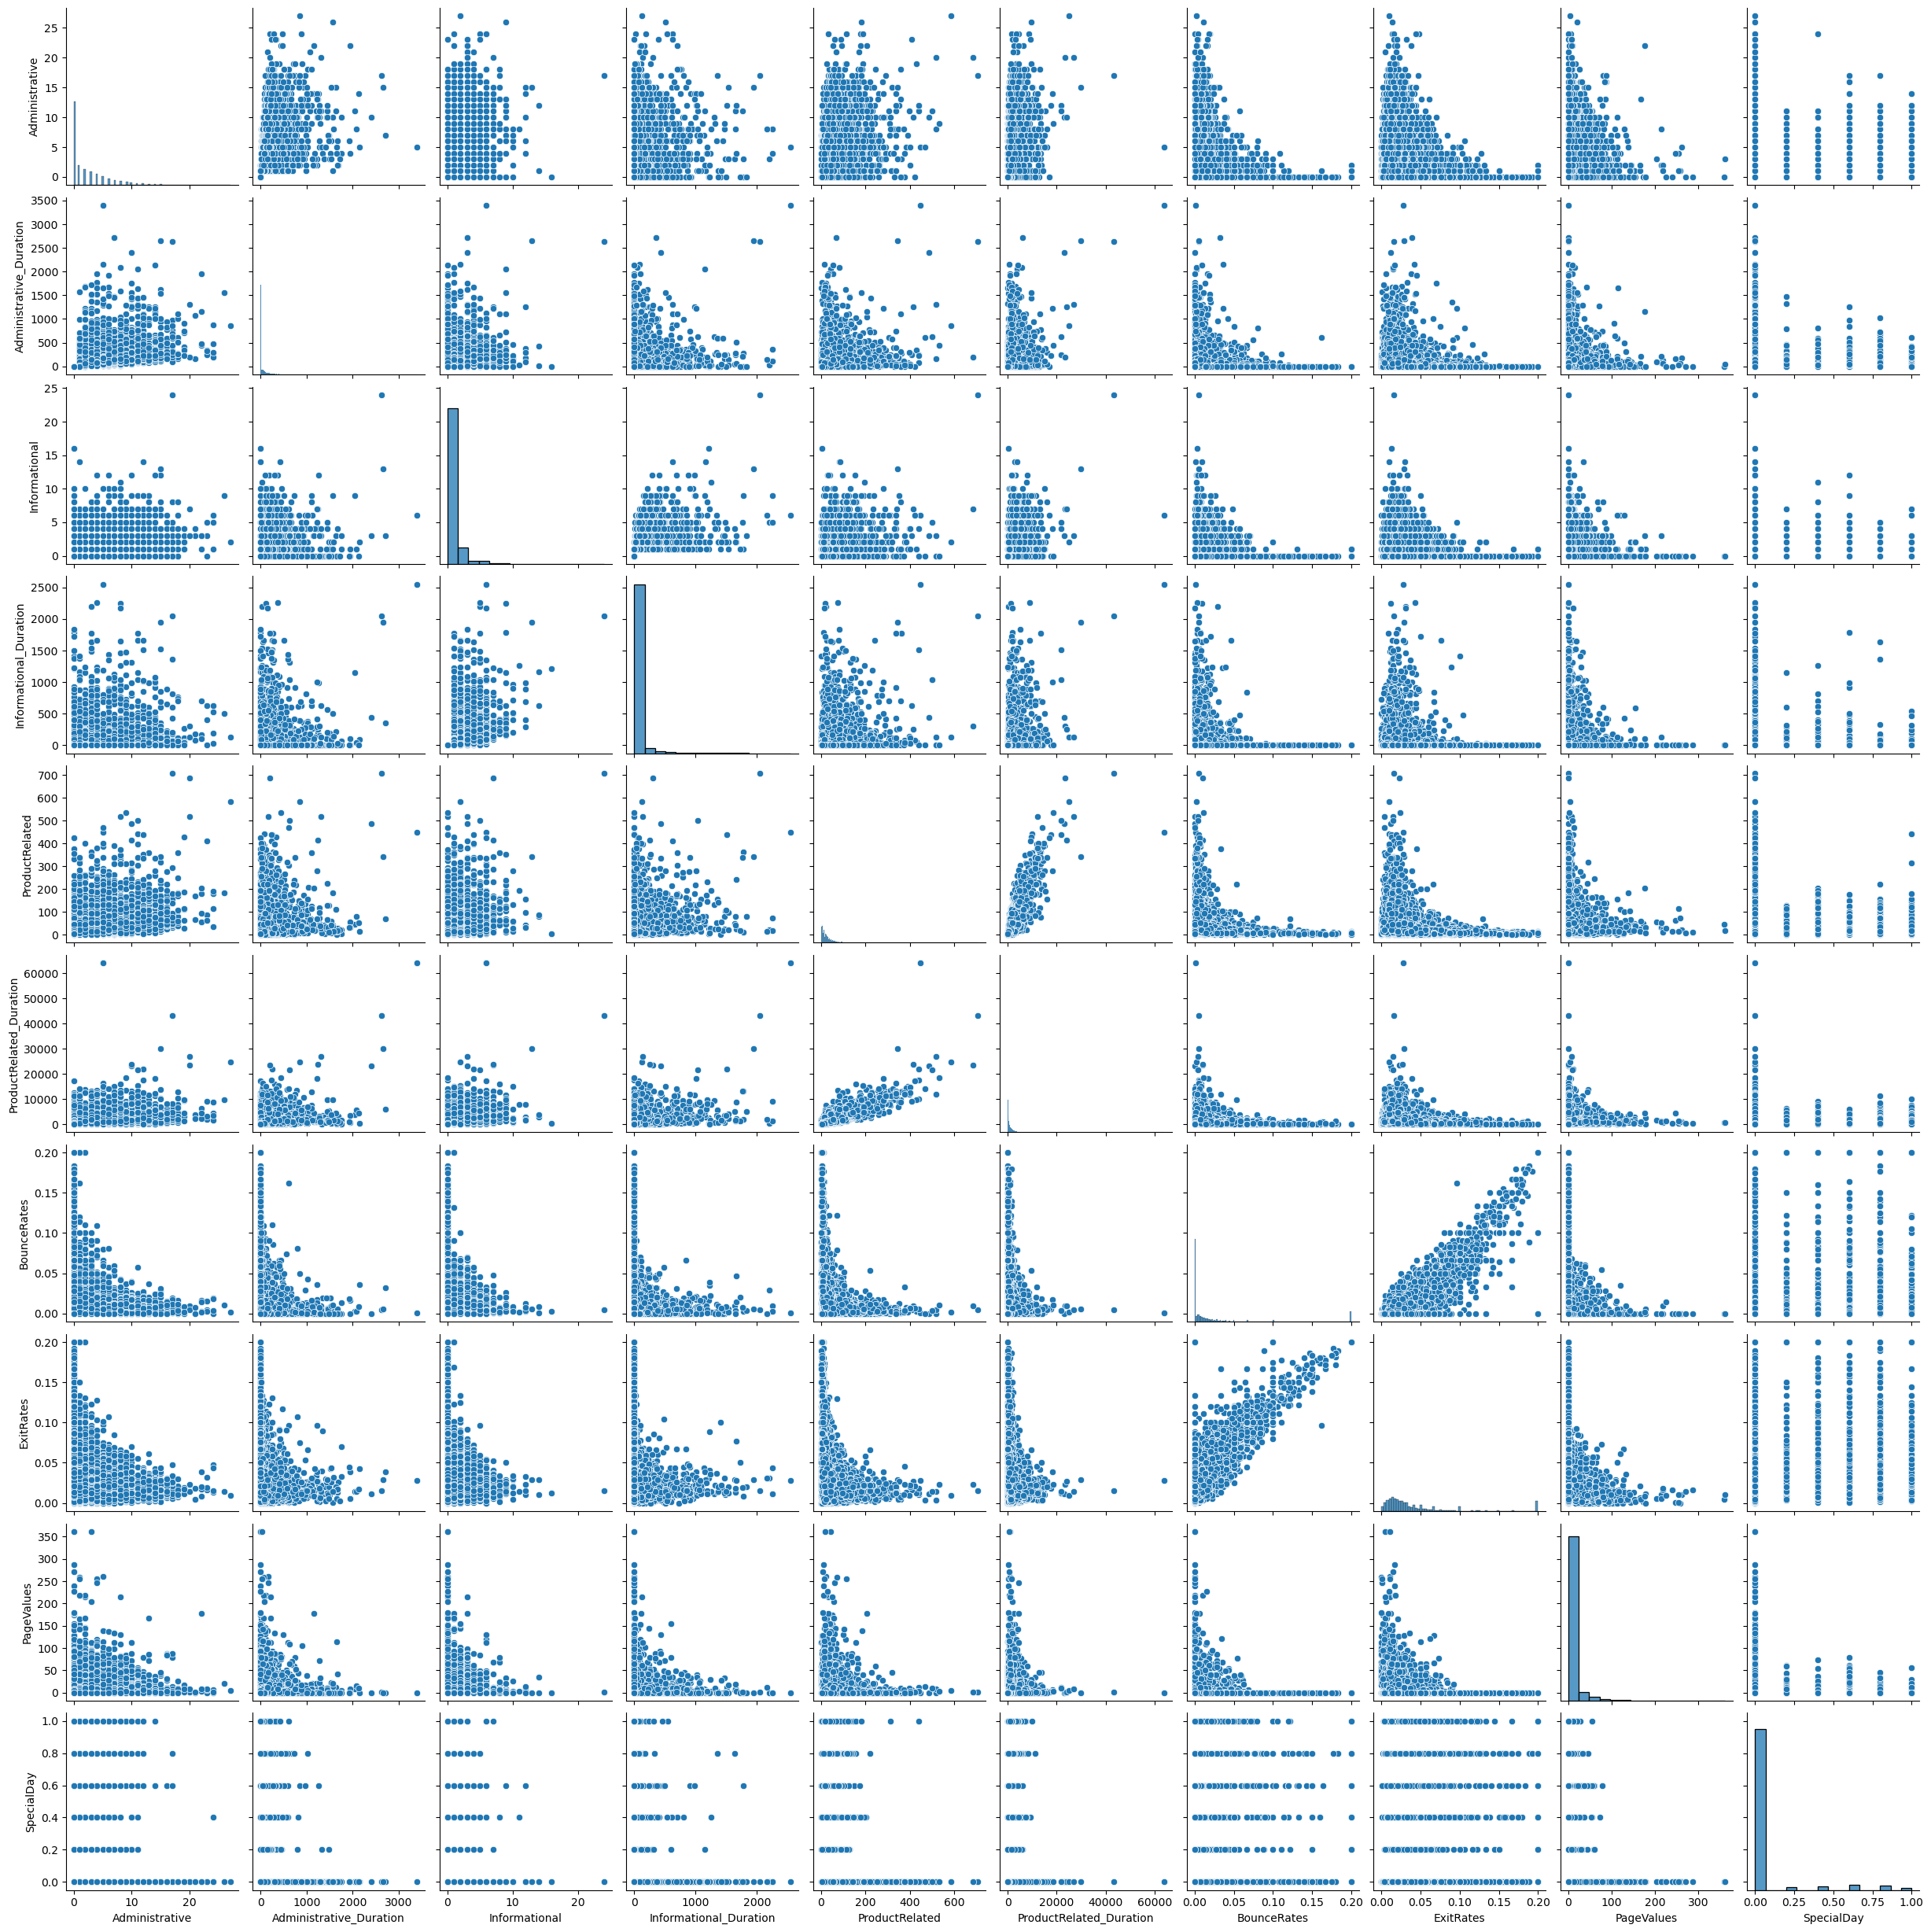

In [27]:
# Verificando graficamente 
sns.pairplot(df_num)

Note a escala dos dados no painel.

In [29]:
# Padronizador 
padroniza = StandardScaler()

# Aplicando a padronização 
df_pad = padroniza.fit_transform(df_num)
df_pad

array([[-0.69699296, -0.4571914 , -0.3964779 , ...,  3.22931559,
        -0.31717784, -0.30882137],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  1.1714725 ,
        -0.31717784, -0.30882137],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  3.22931559,
        -0.31717784, -0.30882137],
       ...,
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  0.89709343,
        -0.31717784, -0.30882137],
       [ 0.50722805, -0.03291592, -0.3964779 , ..., -0.45314046,
        -0.31717784, -0.30882137],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  0.48552481,
        -0.31717784, -0.30882137]])

In [30]:
# Em dataframe
df_pad = pd.DataFrame(df_pad, columns=df_num.columns)
df_pad.head()

Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               -0.244931       -0.691003                -0.624348   
1               -0.244931       -0.668518                -0.590903   
2               -0.244931       -0.691003                -0.624348   
3               -0.244931       -0.668518                -0.622954   
4               -0.244931       -0.488636                -0.296430   

   BounceRates  ExitRates  PageValues  SpecialDay  
0     3.667189   3.229316   -0.317178   -0.308821  
1    -0.457683   1.171473   -0.317178   -0.308821  
2     3.667189   3.229316   -0.317178   -0.308821  
3     0.573535   1.994610   -0.317178   -0.308821  
4    -0.045196   0.142551   -0.317178   -0.308821

In [31]:
# Verificando novamente a covariância
df_pad.cov()

Administrative  Administrative_Duration  \
Administrative                 1.000081                 0.601632   
Administrative_Duration        0.601632                 1.000081   
Informational                  0.376881                 0.302734   
Informational_Duration         0.255869                 0.238050   
ProductRelated                 0.431154                 0.289110   
ProductRelated_Duration        0.373969                 0.355451   
BounceRates                   -0.223581                -0.144182   
ExitRates                     -0.316509                -0.205814   
PageValues                     0.098998                 0.067614   
SpecialDay                    -0.094785                -0.073310   

                         Informational  Informational_Duration  \
Administrative                0.376881                0.255869   
Administrative_Duration       0.302734                0.238050   
Informational                 1.000081                0.619005   
Informational_Duration        0.619005                1.000081   
ProductRelated                0.374195                0.280069   
ProductRelated_Duration       0.387537                0.347392   
BounceRates                  -0.116123               -0.074073   
ExitRates                    -0.163679               -0.105284   
PageValues                    0.048636                0.030863   
SpecialDay                   -0.048223               -0.030579   

                         ProductRelated  ProductRelated_Duration  BounceRates  \
Administrative                 0.431154                 0.373969    -0.223581   
Administrative_Duration        0.289110                 0.355451    -0.144182   
Informational                  0.374195                 0.387537    -0.116123   
Informational_Duration         0.280069                 0.347392    -0.074073   
ProductRelated                 1.000081                 0.860997    -0.204594   
ProductRelated_Duration        0.860997                 1.000081    -0.184556   
BounceRates                   -0.204594                -0.184556     1.000081   
ExitRates                     -0.292550                -0.252005     0.913078   
PageValues                     0.056286                 0.052827    -0.119396   
SpecialDay                    -0.023960                -0.036383     0.072708   

                         ExitRates  PageValues  SpecialDay  
Administrative           -0.316509    0.098998   -0.094785  
Administrative_Duration  -0.205814    0.067614   -0.073310  
Informational            -0.163679    0.048636   -0.048223  
Informational_Duration   -0.105284    0.030863   -0.030579  
ProductRelated           -0.292550    0.056286   -0.023960  
ProductRelated_Duration  -0.252005    0.052827   -0.036383  
BounceRates               0.913078   -0.119396    0.072708  
ExitRates                 1.000081   -0.174512    0.102250  
PageValues               -0.174512    1.000081   -0.063546  
SpecialDay                0.102250   -0.063546    1.000081

Note que a variância dos dados está padronizada e que a covariância possui um intervalo mais bem definido.

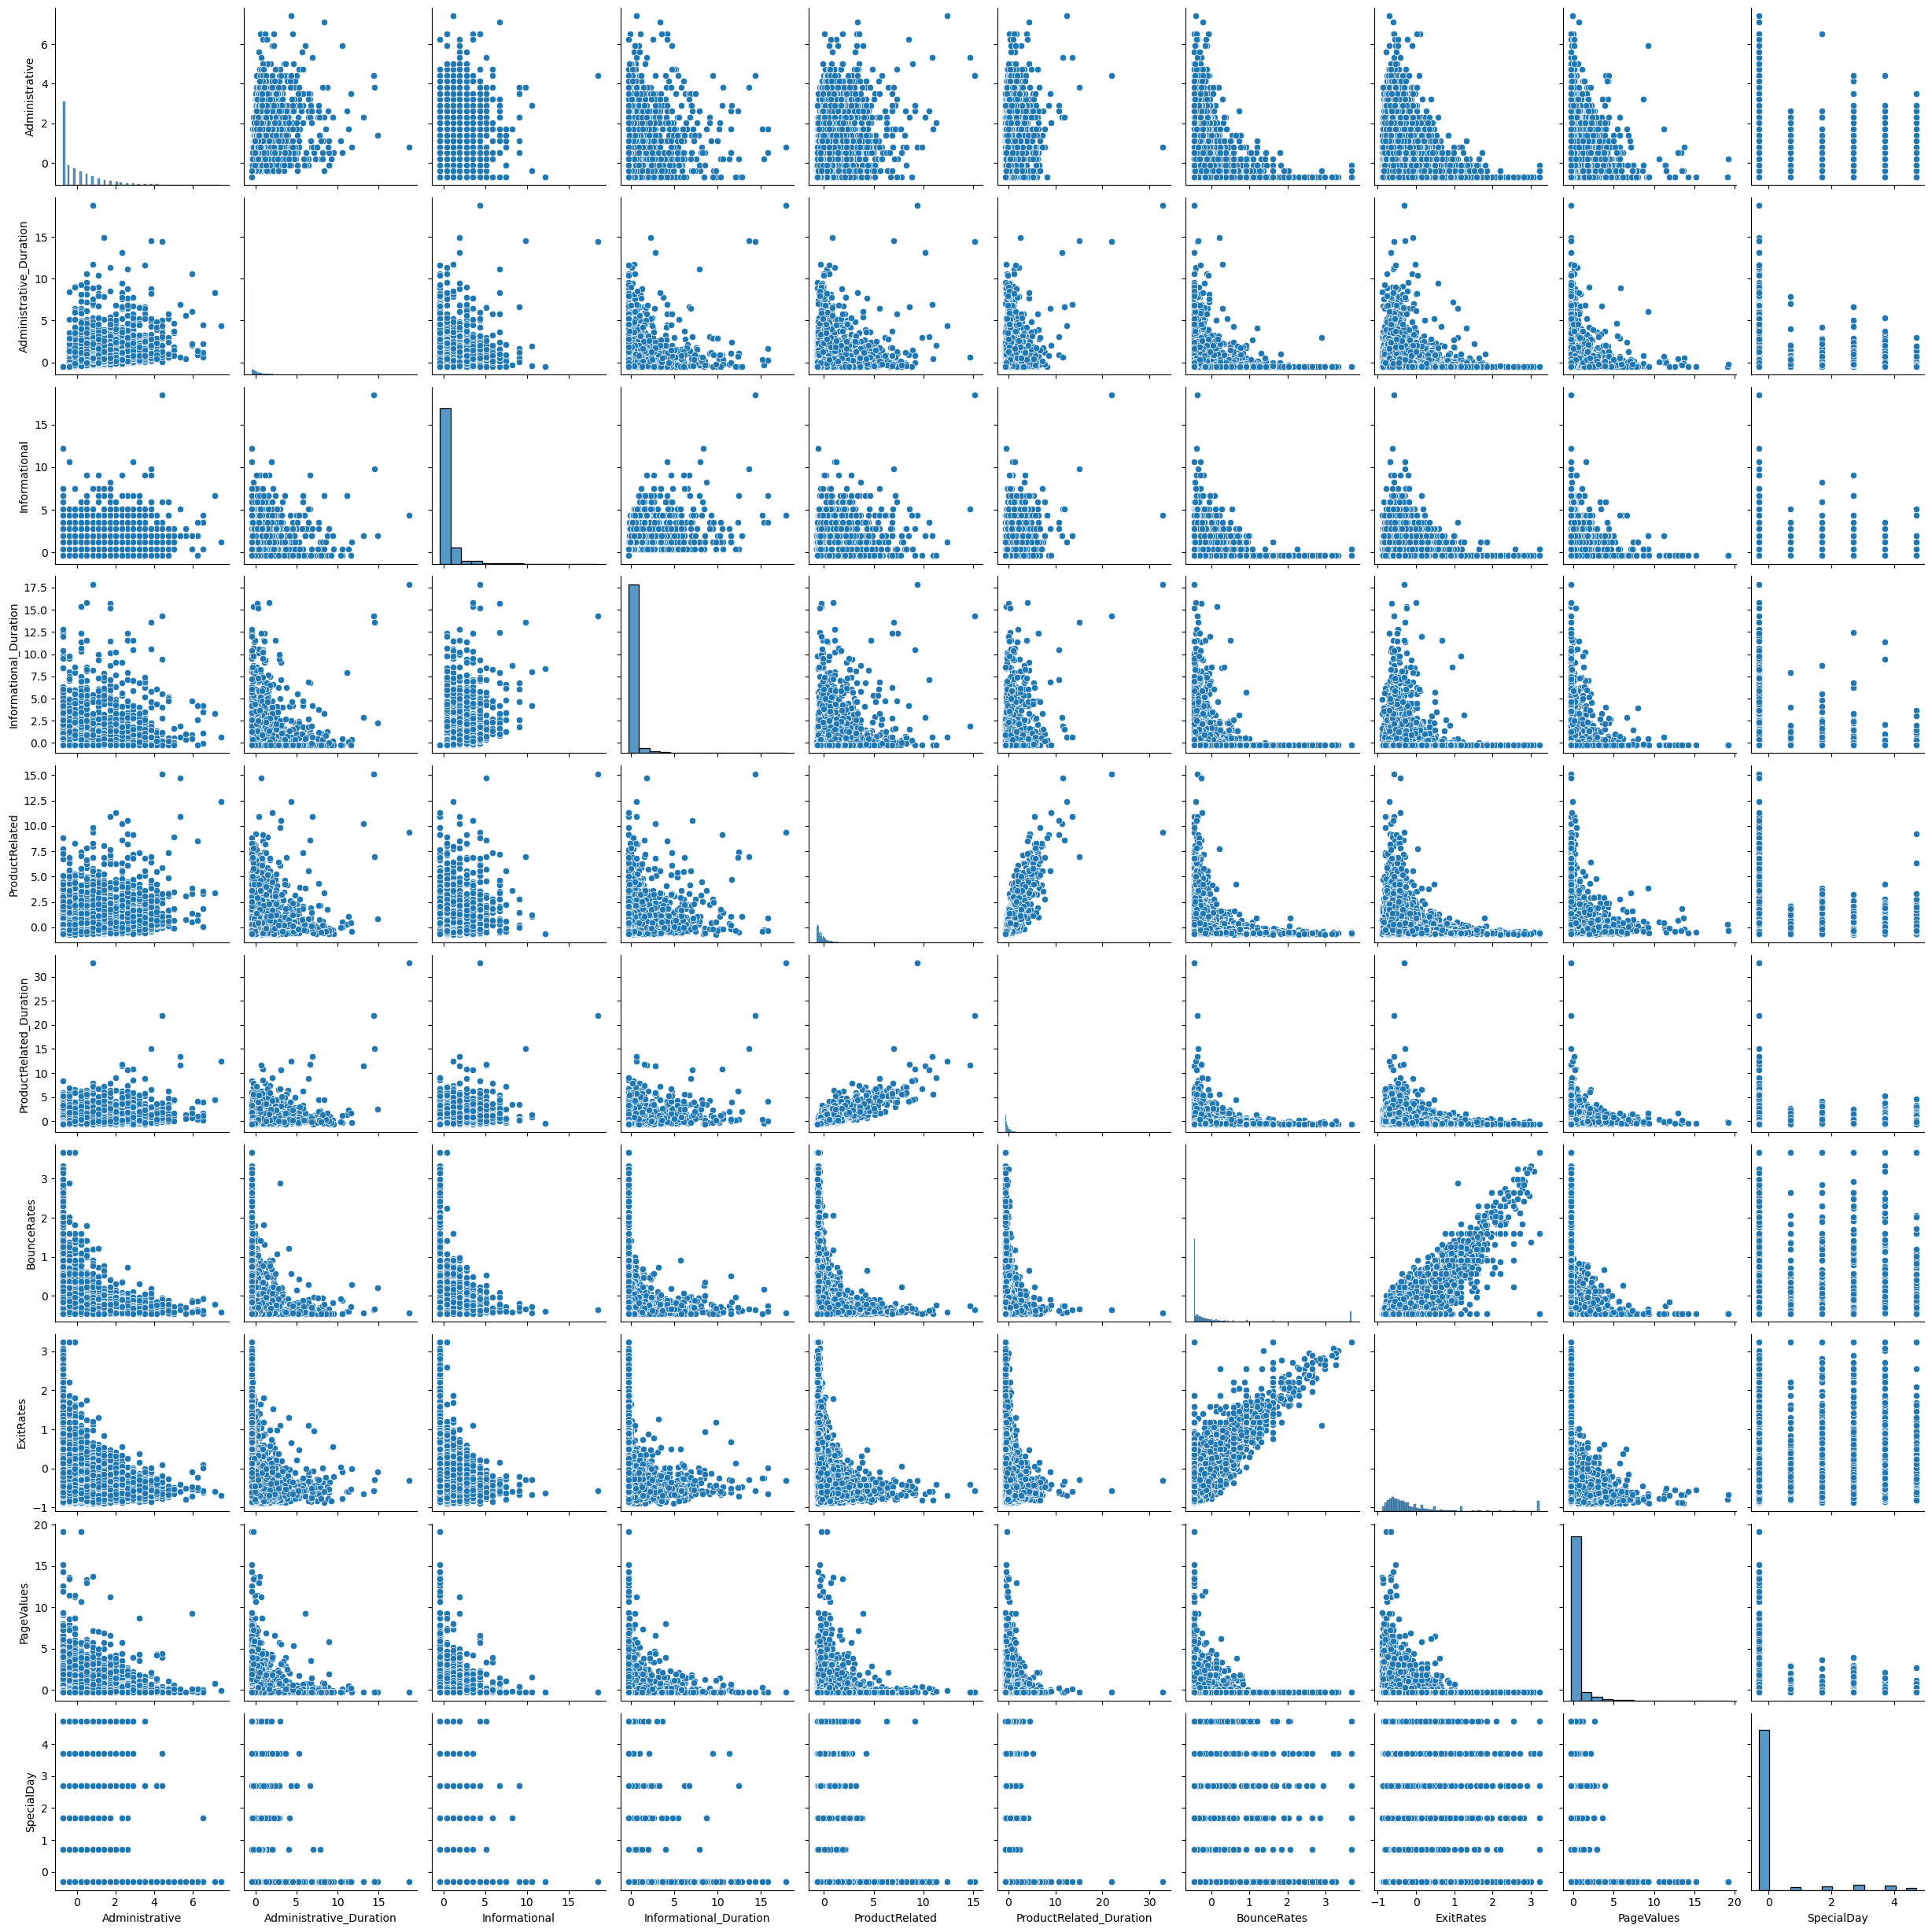

In [33]:
sns.pairplot(df_pad)

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

Como apresentado na atividade acima as variáveis a serem utilizadas serão:

In [36]:
df2.columns.values

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay', 'Month', 'VisitorType', 'Weekend',
       'Revenue'], dtype=object)

In [37]:
# DataFrame com os dados não numérico

df3 = df2[['Month', 'VisitorType', 'Weekend', 'Revenue']]
df3 = pd.get_dummies(df3, drop_first=False)
print(df3.shape)
df3.head()

(12330, 15)


Weekend  Revenue  Month_Aug  Month_Dec  Month_Feb  Month_Jul  Month_June  \
0    False    False      False      False       True      False       False   
1    False    False      False      False       True      False       False   
2    False    False      False      False       True      False       False   
3    False    False      False      False       True      False       False   
4     True    False      False      False       True      False       False   

   Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
0      False      False      False      False      False   
1      False      False      False      False      False   
2      False      False      False      False      False   
3      False      False      False      False      False   
4      False      False      False      False      False   

   VisitorType_New_Visitor  VisitorType_Other  VisitorType_Returning_Visitor  
0                    False              False                           True  
1                    False              False                           True  
2                    False              False                           True  
3                    False              False                           True  
4                    False              False                           True

In [38]:
# Os numéricos padronizados
print(df_pad.shape)
df_pad.head()

(12330, 10)


Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               -0.244931       -0.691003                -0.624348   
1               -0.244931       -0.668518                -0.590903   
2               -0.244931       -0.691003                -0.624348   
3               -0.244931       -0.668518                -0.622954   
4               -0.244931       -0.488636                -0.296430   

   BounceRates  ExitRates  PageValues  SpecialDay  
0     3.667189   3.229316   -0.317178   -0.308821  
1    -0.457683   1.171473   -0.317178   -0.308821  
2     3.667189   3.229316   -0.317178   -0.308821  
3     0.573535   1.994610   -0.317178   -0.308821  
4    -0.045196   0.142551   -0.317178   -0.308821

##### Concatenando os dados numérios e dummies definidos

In [40]:
df_full = pd.concat([df_pad, df3], axis=1)
print(df_full.shape)
df_full.head()

(12330, 25)


Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               -0.244931       -0.691003                -0.624348   
1               -0.244931       -0.668518                -0.590903   
2               -0.244931       -0.691003                -0.624348   
3               -0.244931       -0.668518                -0.622954   
4               -0.244931       -0.488636                -0.296430   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  Month_Jul  Month_June  \
0     3.667189   3.229316   -0.317178   -0.308821  ...      False       False   
1    -0.457683   1.171473   -0.317178   -0.308821  ...      False       False   
2     3.667189   3.229316   -0.317178   -0.308821  ...      False       False   
3     0.573535   1.994610   -0.317178   -0.308821  ...      False       False   
4    -0.045196   0.142551   -0.317178   -0.308821  ...      False       False   

   Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
0      False      False      False      False      False   
1      False      False      False      False      False   
2      False      False      False      False      False   
3      False      False      False      False      False   
4      False      False      False      False      False   

   VisitorType_New_Visitor  VisitorType_Other  VisitorType_Returning_Visitor  
0                    False              False                           True  
1                    False              False                           True  
2                    False              False                           True  
3                    False              False                           True  
4                    False              False                           True  

[5 rows x 25 columns]

In [41]:
# dados faltantes
df_full.isna().sum()

Administrative                   0
Administrative_Duration          0
Informational                    0
Informational_Duration           0
ProductRelated                   0
ProductRelated_Duration          0
BounceRates                      0
ExitRates                        0
PageValues                       0
SpecialDay                       0
Weekend                          0
Revenue                          0
Month_Aug                        0
Month_Dec                        0
Month_Feb                        0
Month_Jul                        0
Month_June                       0
Month_Mar                        0
Month_May                        0
Month_Nov                        0
Month_Oct                        0
Month_Sep                        0
VisitorType_New_Visitor          0
VisitorType_Other                0
VisitorType_Returning_Visitor    0
dtype: int64

Como podemos ver, não há dados faltantes.

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

##### Inicialmente vamos definir um vetor para identificação das variáveis qualitativas e quantitativas

In [45]:
vars_cat = [True if var in list(df3.columns) else False for var in df_full.columns]
print(vars_cat)

[False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


##### Agora que temos as variáveis dummies indicadas podemos calcular as distâncias via `gower_matrix`

In [47]:
gower_dist = gower_matrix(df_full, cat_features=vars_cat)

In [48]:
print(gower_dist.shape)
gower_dist[:5, :5]

(12330, 12330)


array([[0.        , 0.06009675, 0.        , 0.0420584 , 0.10690299],
       [0.06009675, 0.        , 0.06009675, 0.01803835, 0.05480623],
       [0.        , 0.06009675, 0.        , 0.0420584 , 0.10690299],
       [0.0420584 , 0.01803835, 0.0420584 , 0.        , 0.06484459],
       [0.10690299, 0.05480623, 0.10690299, 0.06484459, 0.        ]],
      dtype=float32)

In [49]:
# Ajustando o formato da matriz (formato flat)
gdv = squareform(gower_dist, force='tovector')
print(gdv.shape) #Agora temos um vetor
gdv

(76008285,)


array([0.06009675, 0.        , 0.0420584 , ..., 0.07720985, 0.1009388 ,
       0.13681531], dtype=float32)

##### Vamos agora treinar o agrupamento

In [51]:
z = linkage(gdv, method='complete') 
# Bem diferente dos métodos de treinamento até então estudados

In [52]:
# Gerando um dataFrame
df_z = pd.DataFrame(z, columns=['id1', 'id2', 'distance', 'n'])
print(df_z.shape)
df_z.tail(8)

(12329, 4)


id1      id2  distance        n
12321  24632.0  24638.0  0.333240    321.0
12322  24631.0  24645.0  0.333890   3469.0
12323  24649.0  24652.0  0.342350   4835.0
12324  24644.0  24651.0  0.359632   1955.0
12325  24642.0  24654.0  0.367802   2001.0
12326  24650.0  24653.0  0.375399  10326.0
12327  24655.0  24656.0  0.415399  12327.0
12328  24633.0  24657.0  0.475237  12330.0

Os pontos são as colunas `id1` e `id2`, a distância entre eles é dada por `distance` e os clusters são descritos em `n`.

##### Façamos um dendrograma

- Utilizando o `dendrogram` do scipy

Leaves 11957


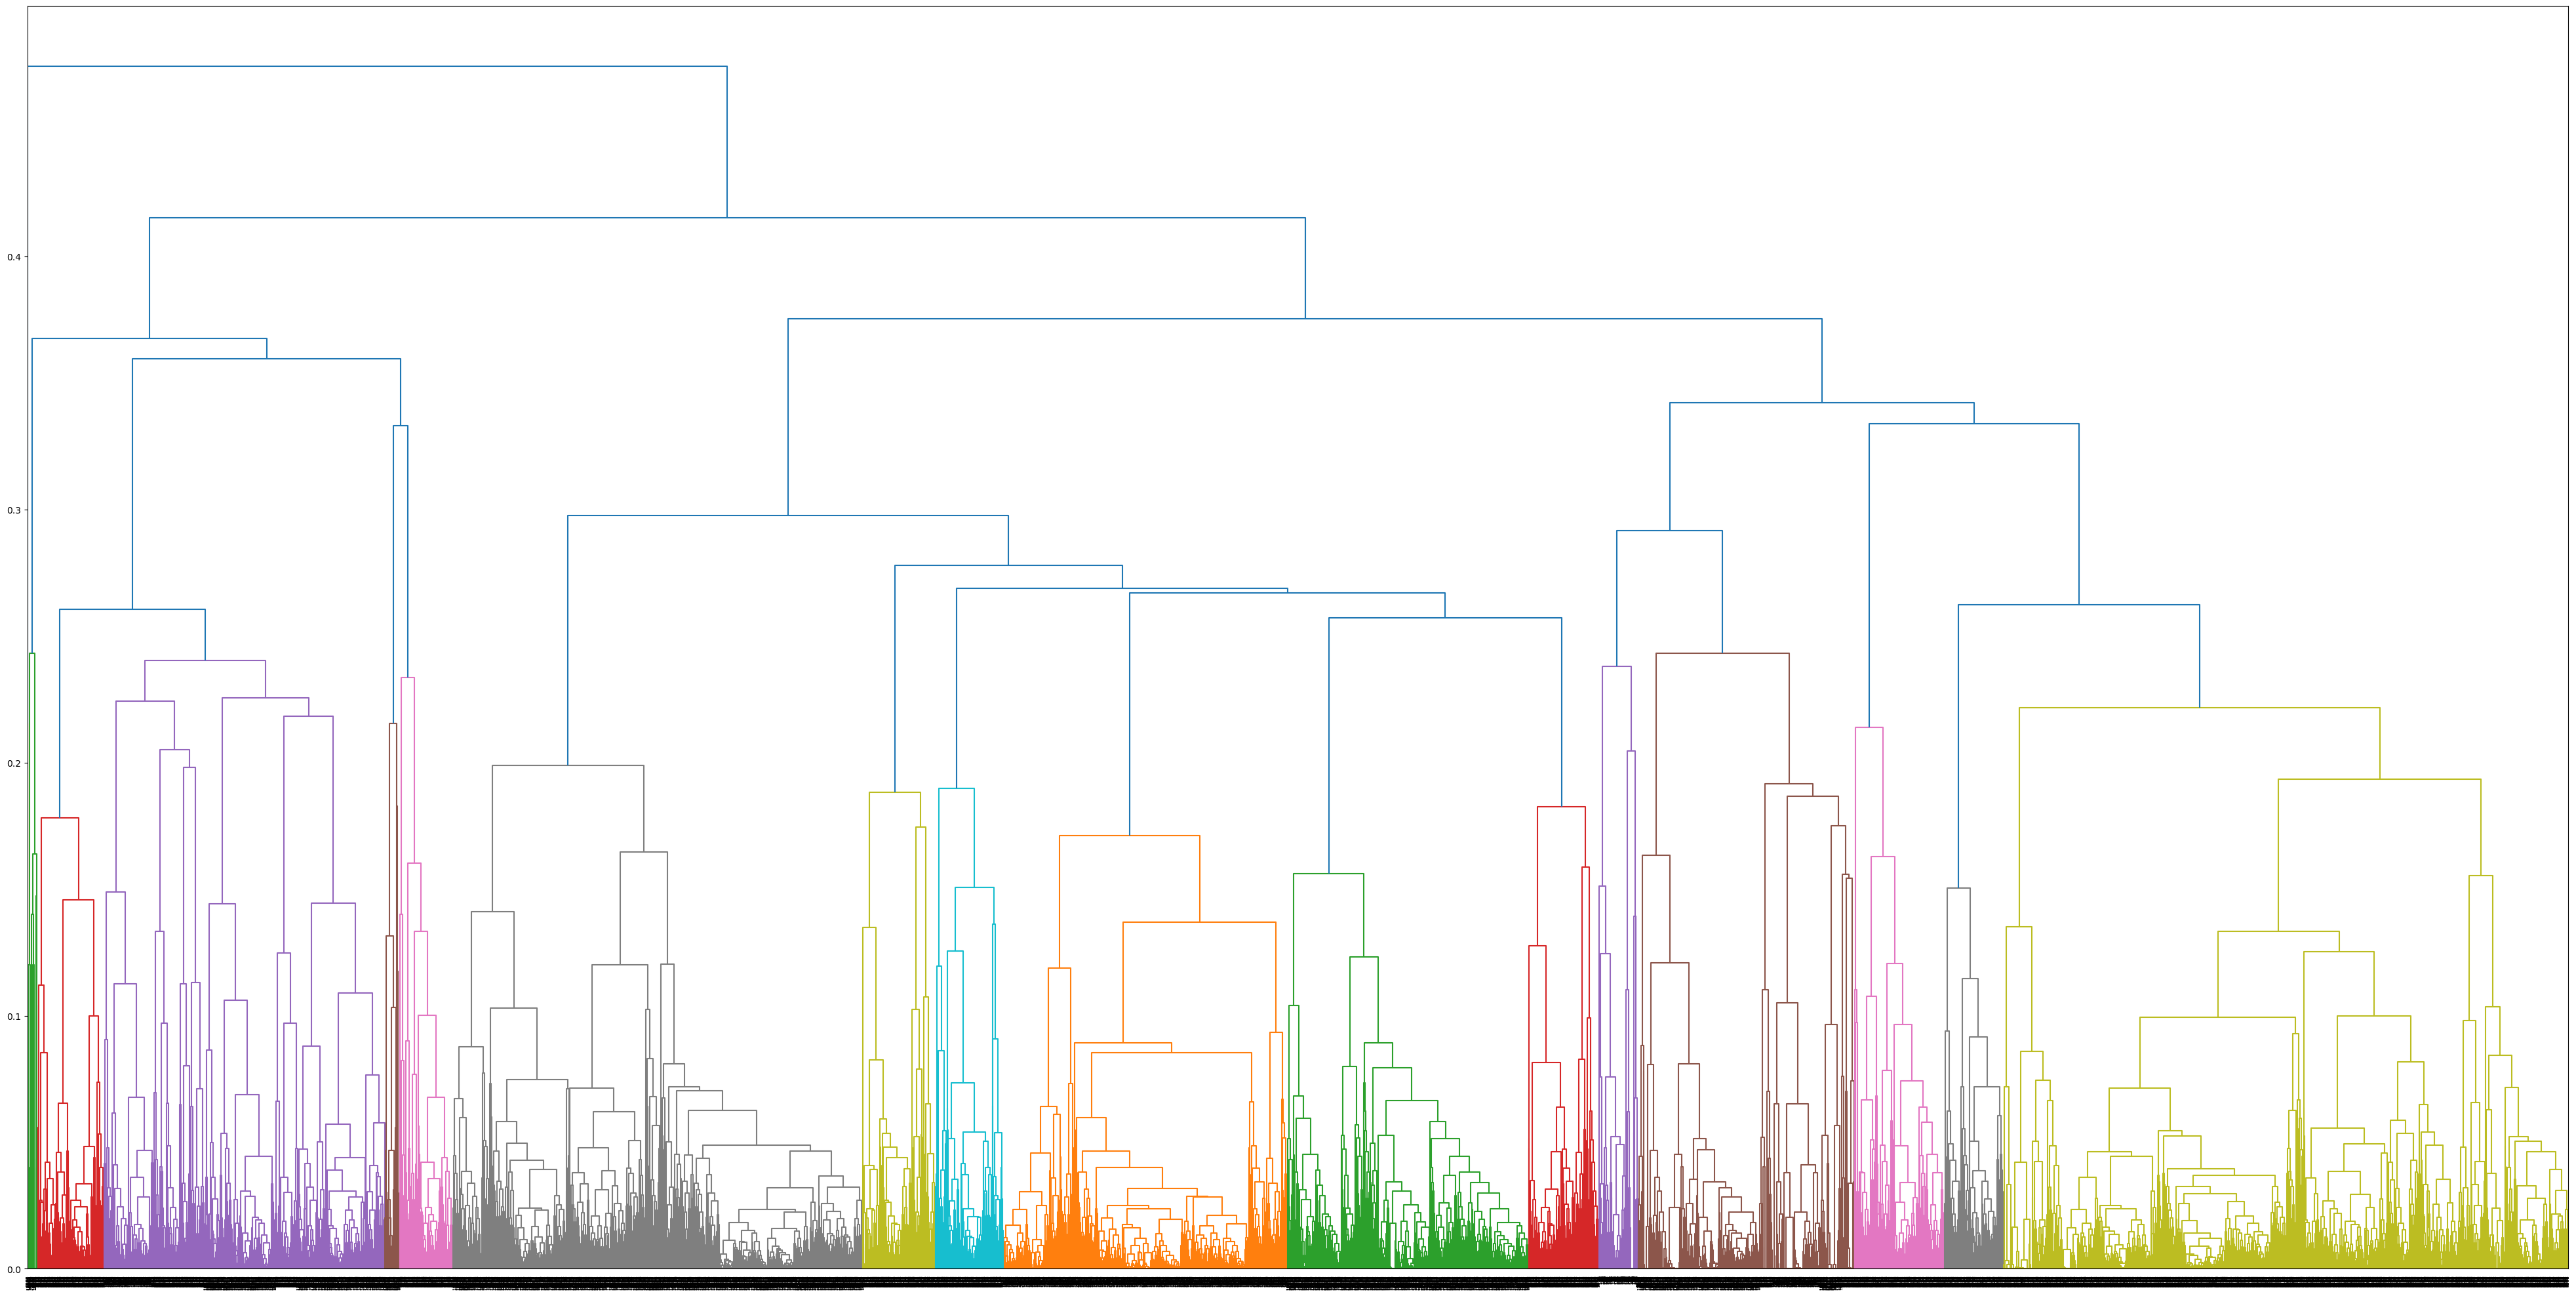

In [55]:
plt.figure(figsize=[50,25])
dn = dendrogram(z,
                p = 30,
                truncate_mode = 'level',
                show_leaf_counts = True,
                color_threshold = .25)

plt.savefig('Dendrogram.png', dpi=500)
print(f'Leaves {len(dn['leaves'])}')

In [56]:
# Avaliando a frequência de cada grupo

# Utilizando a função fcluster para criar um agrupamento com 3 e 4 grupos
df_full['com_3_grupos'] = fcluster(z, 3, criterion='maxclust')
df_full.com_3_grupos.value_counts()

com_3_grupos
3    10326
2     2001
1        3
Name: count, dtype: int64

In [57]:
# Agrupamento com 4 grupos

df_full['com_4_grupos'] = fcluster(z, 4, criterion='maxclust')
df_full.com_4_grupos.value_counts()

com_4_grupos
3    5491
4    4835
2    2001
1       3
Name: count, dtype: int64

In [58]:
df_full.head()

Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               -0.244931       -0.691003                -0.624348   
1               -0.244931       -0.668518                -0.590903   
2               -0.244931       -0.691003                -0.624348   
3               -0.244931       -0.668518                -0.622954   
4               -0.244931       -0.488636                -0.296430   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  Month_Mar  Month_May  \
0     3.667189   3.229316   -0.317178   -0.308821  ...      False      False   
1    -0.457683   1.171473   -0.317178   -0.308821  ...      False      False   
2     3.667189   3.229316   -0.317178   -0.308821  ...      False      False   
3     0.573535   1.994610   -0.317178   -0.308821  ...      False      False   
4    -0.045196   0.142551   -0.317178   -0.308821  ...      False      False   

   Month_Nov  Month_Oct  Month_Sep  VisitorType_New_Visitor  \
0      False      False      False                    False   
1      False      False      False                    False   
2      False      False      False                    False   
3      False      False      False                    False   
4      False      False      False                    False   

   VisitorType_Other  VisitorType_Returning_Visitor  com_3_grupos  \
0              False                           True             3   
1              False                           True             3   
2              False                           True             3   
3              False                           True             3   
4              False                           True             3   

   com_4_grupos  
0             4  
1             4  
2             4  
3             4  
4             4  

[5 rows x 27 columns]

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [60]:
# Adicionando os grupos ao dataframe inicial

df_group = df.copy()

df_group['com_3_grupos'] = df_full[['com_3_grupos']]
df_group['com_4_grupos'] = df_full[['com_4_grupos']]

# As variáveis
print(df_group.columns)
# df
df_group.head()

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue', 'com_3_grupos', 'com_4_grupos'],
      dtype='object')


Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  \
0        1       1            1  Returning_Visitor    False    False   
1        2       1            2  Returning_Visitor    False    False   
2        1       9            3  Returning_Visitor    False    False   
3        2       2            4  Returning_Visitor    False    False   
4        3       1            4  Returning_Visitor     True    False   

   com_3_grupos  com_4_grupos  
0             3             4  
1             3             4  
2             3             4  
3             3             4  
4             3             4

##### Agrupamento com 3 grupos

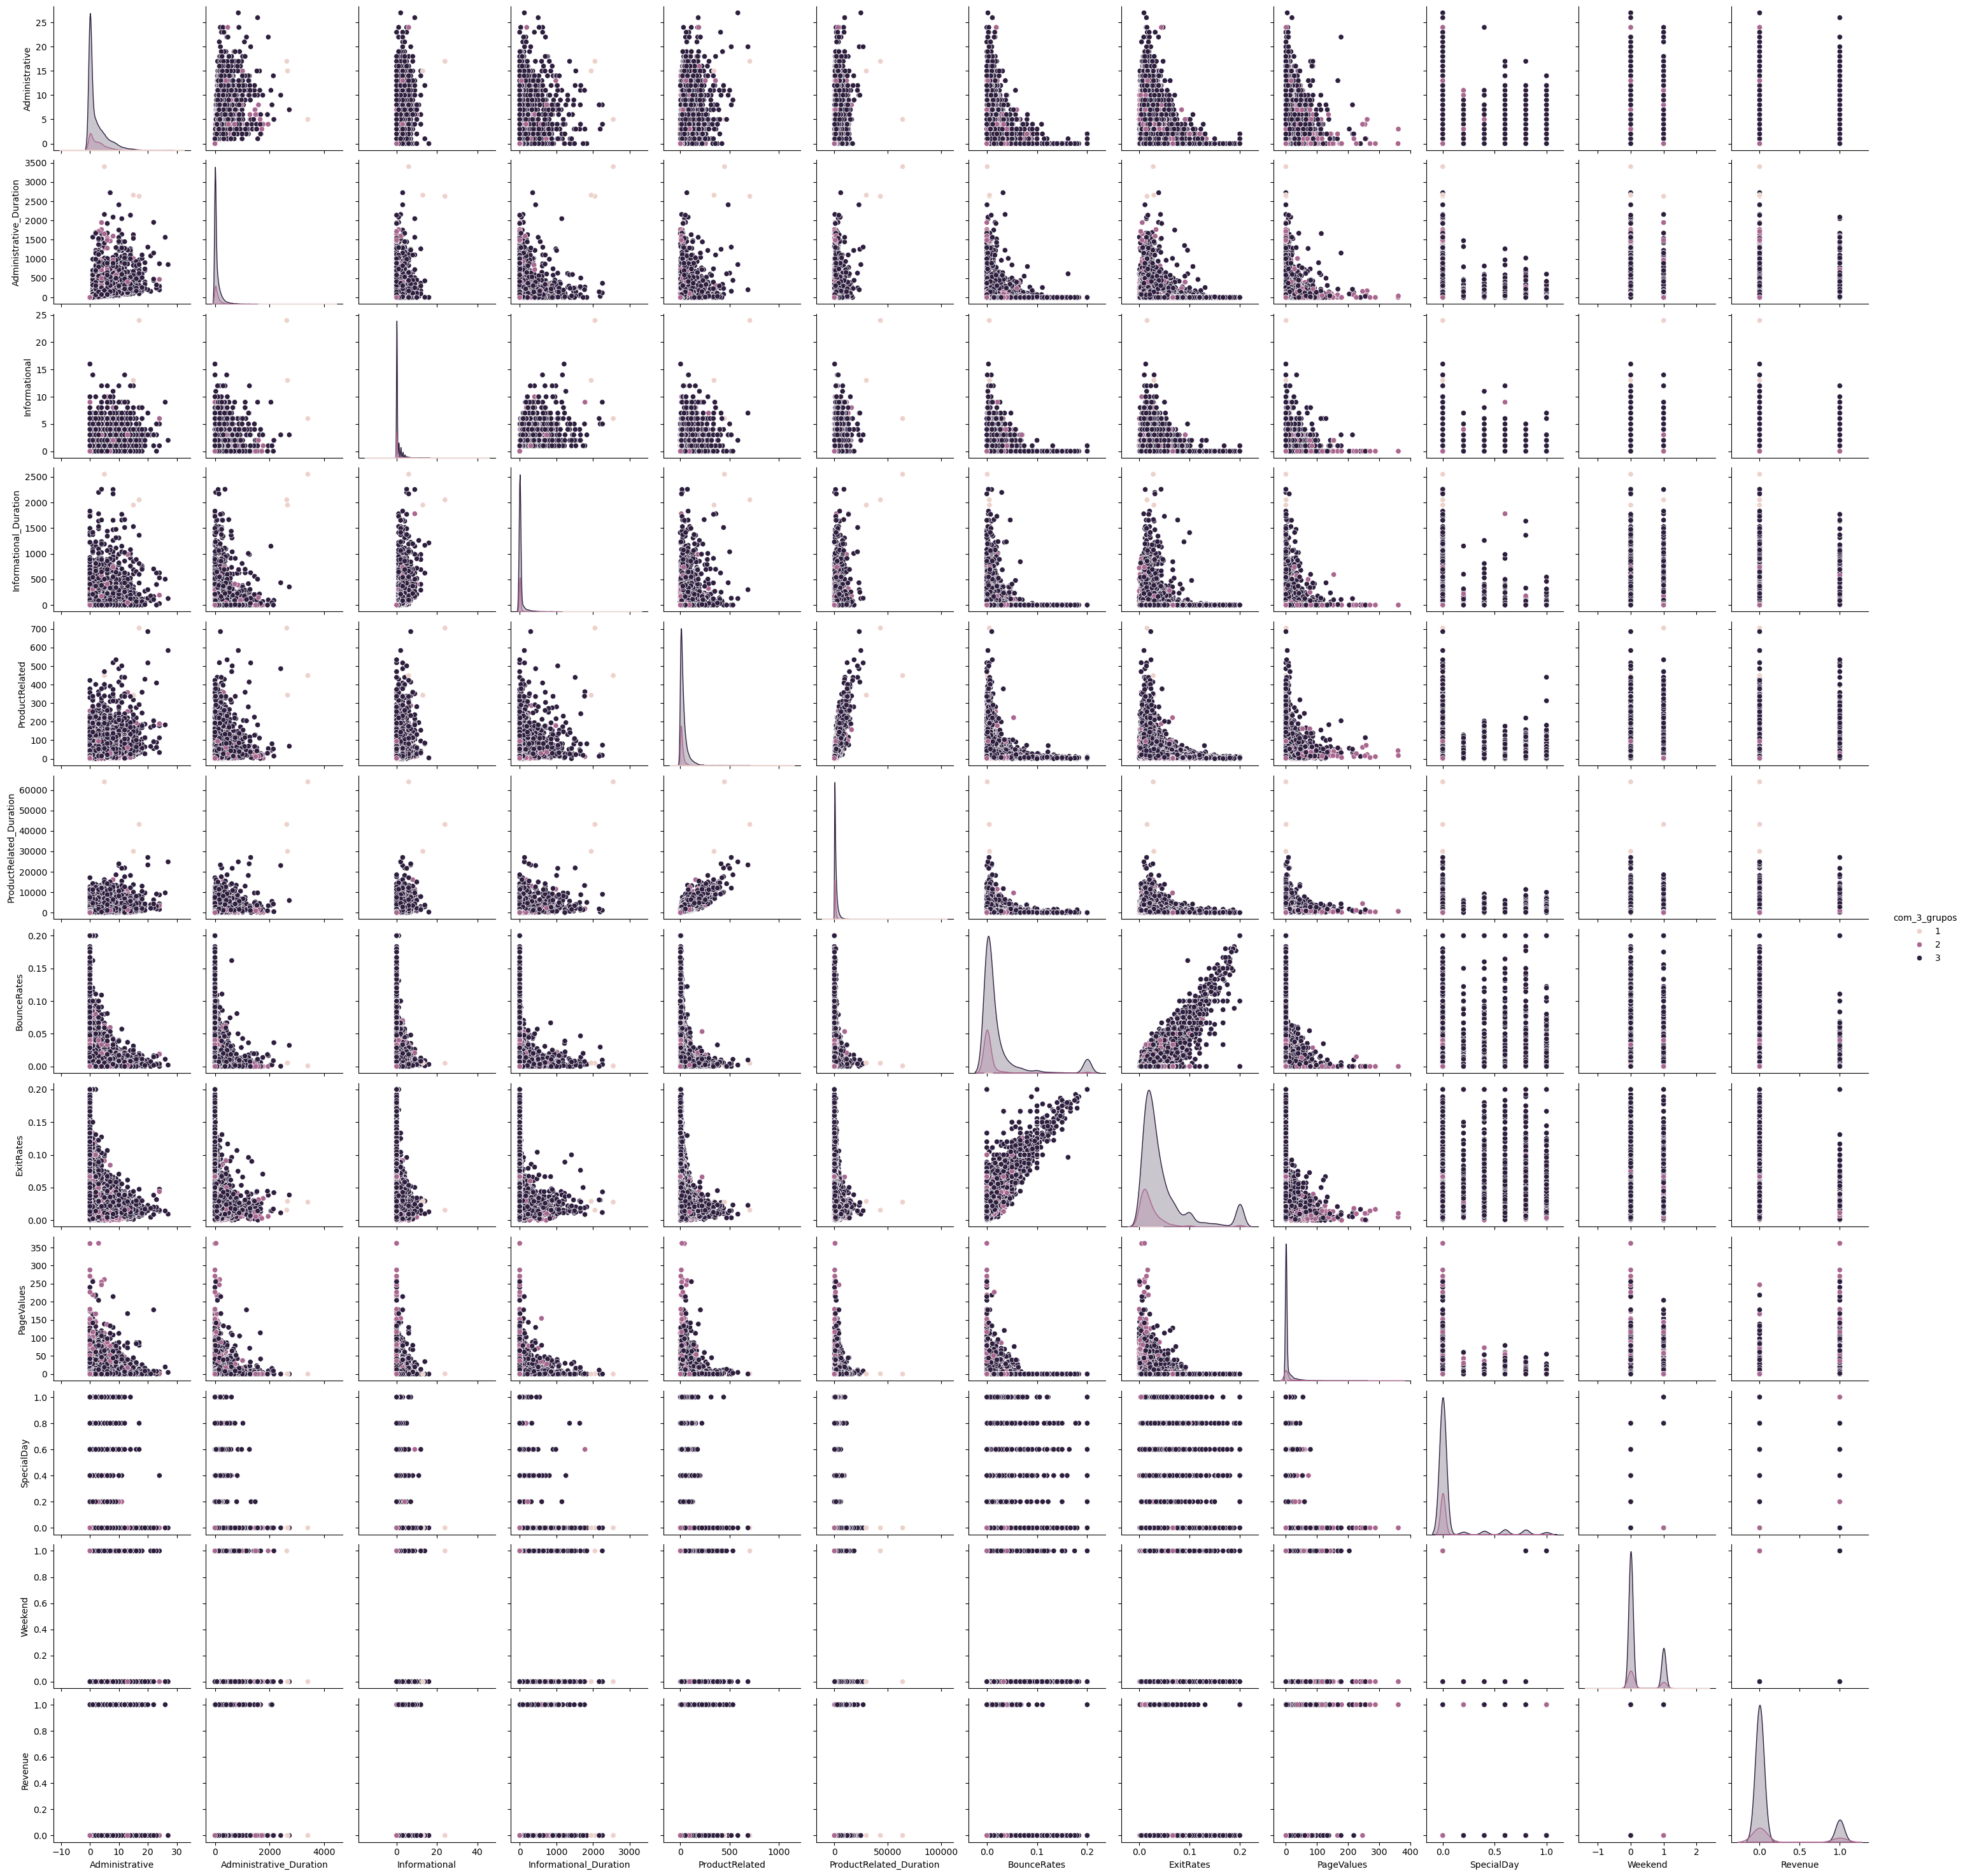

In [62]:
# Distribuição para o agrupamento com 3 grupos
vars = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'VisitorType', 'Weekend', 'Revenue', 'com_3_grupos']

sns.pairplot(df_group[vars], hue='com_3_grupos')
plt.savefig('paiplot_3_grupos.png', dpi=300)

Revenue        False   True 
com_3_grupos                
1                3.0     0.0
2             1541.0   460.0
3             8878.0  1448.0

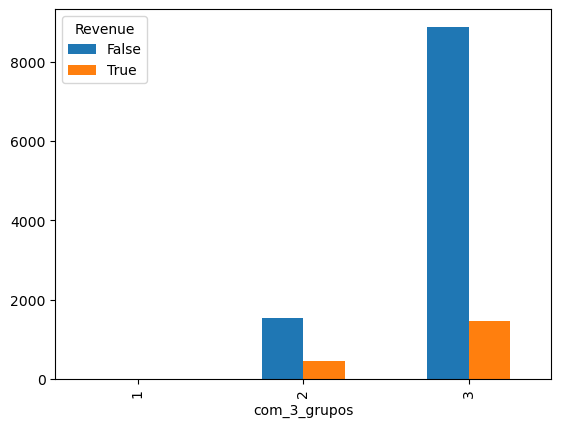

In [63]:
# Avaliando com_3_grupos

com_3 = df_group.groupby(['com_3_grupos', 'Revenue'])['com_3_grupos'].count().unstack().fillna(0)
#plot
com_3.plot.bar()

com_3

In [64]:
# Tabela cruzada
pd.crosstab(df_group['Revenue'], df_group['com_3_grupos'])

com_3_grupos  1     2     3
Revenue                    
False         3  1541  8878
True          0   460  1448

In [65]:
# Tabela cruzada normalizada na coluna
pd.crosstab(df_group['Revenue'], df_group['com_3_grupos'], normalize='columns')

com_3_grupos    1         2         3
Revenue                              
False         1.0  0.770115  0.859771
True          0.0  0.229885  0.140229

##### Agrupamento com 4 grupos

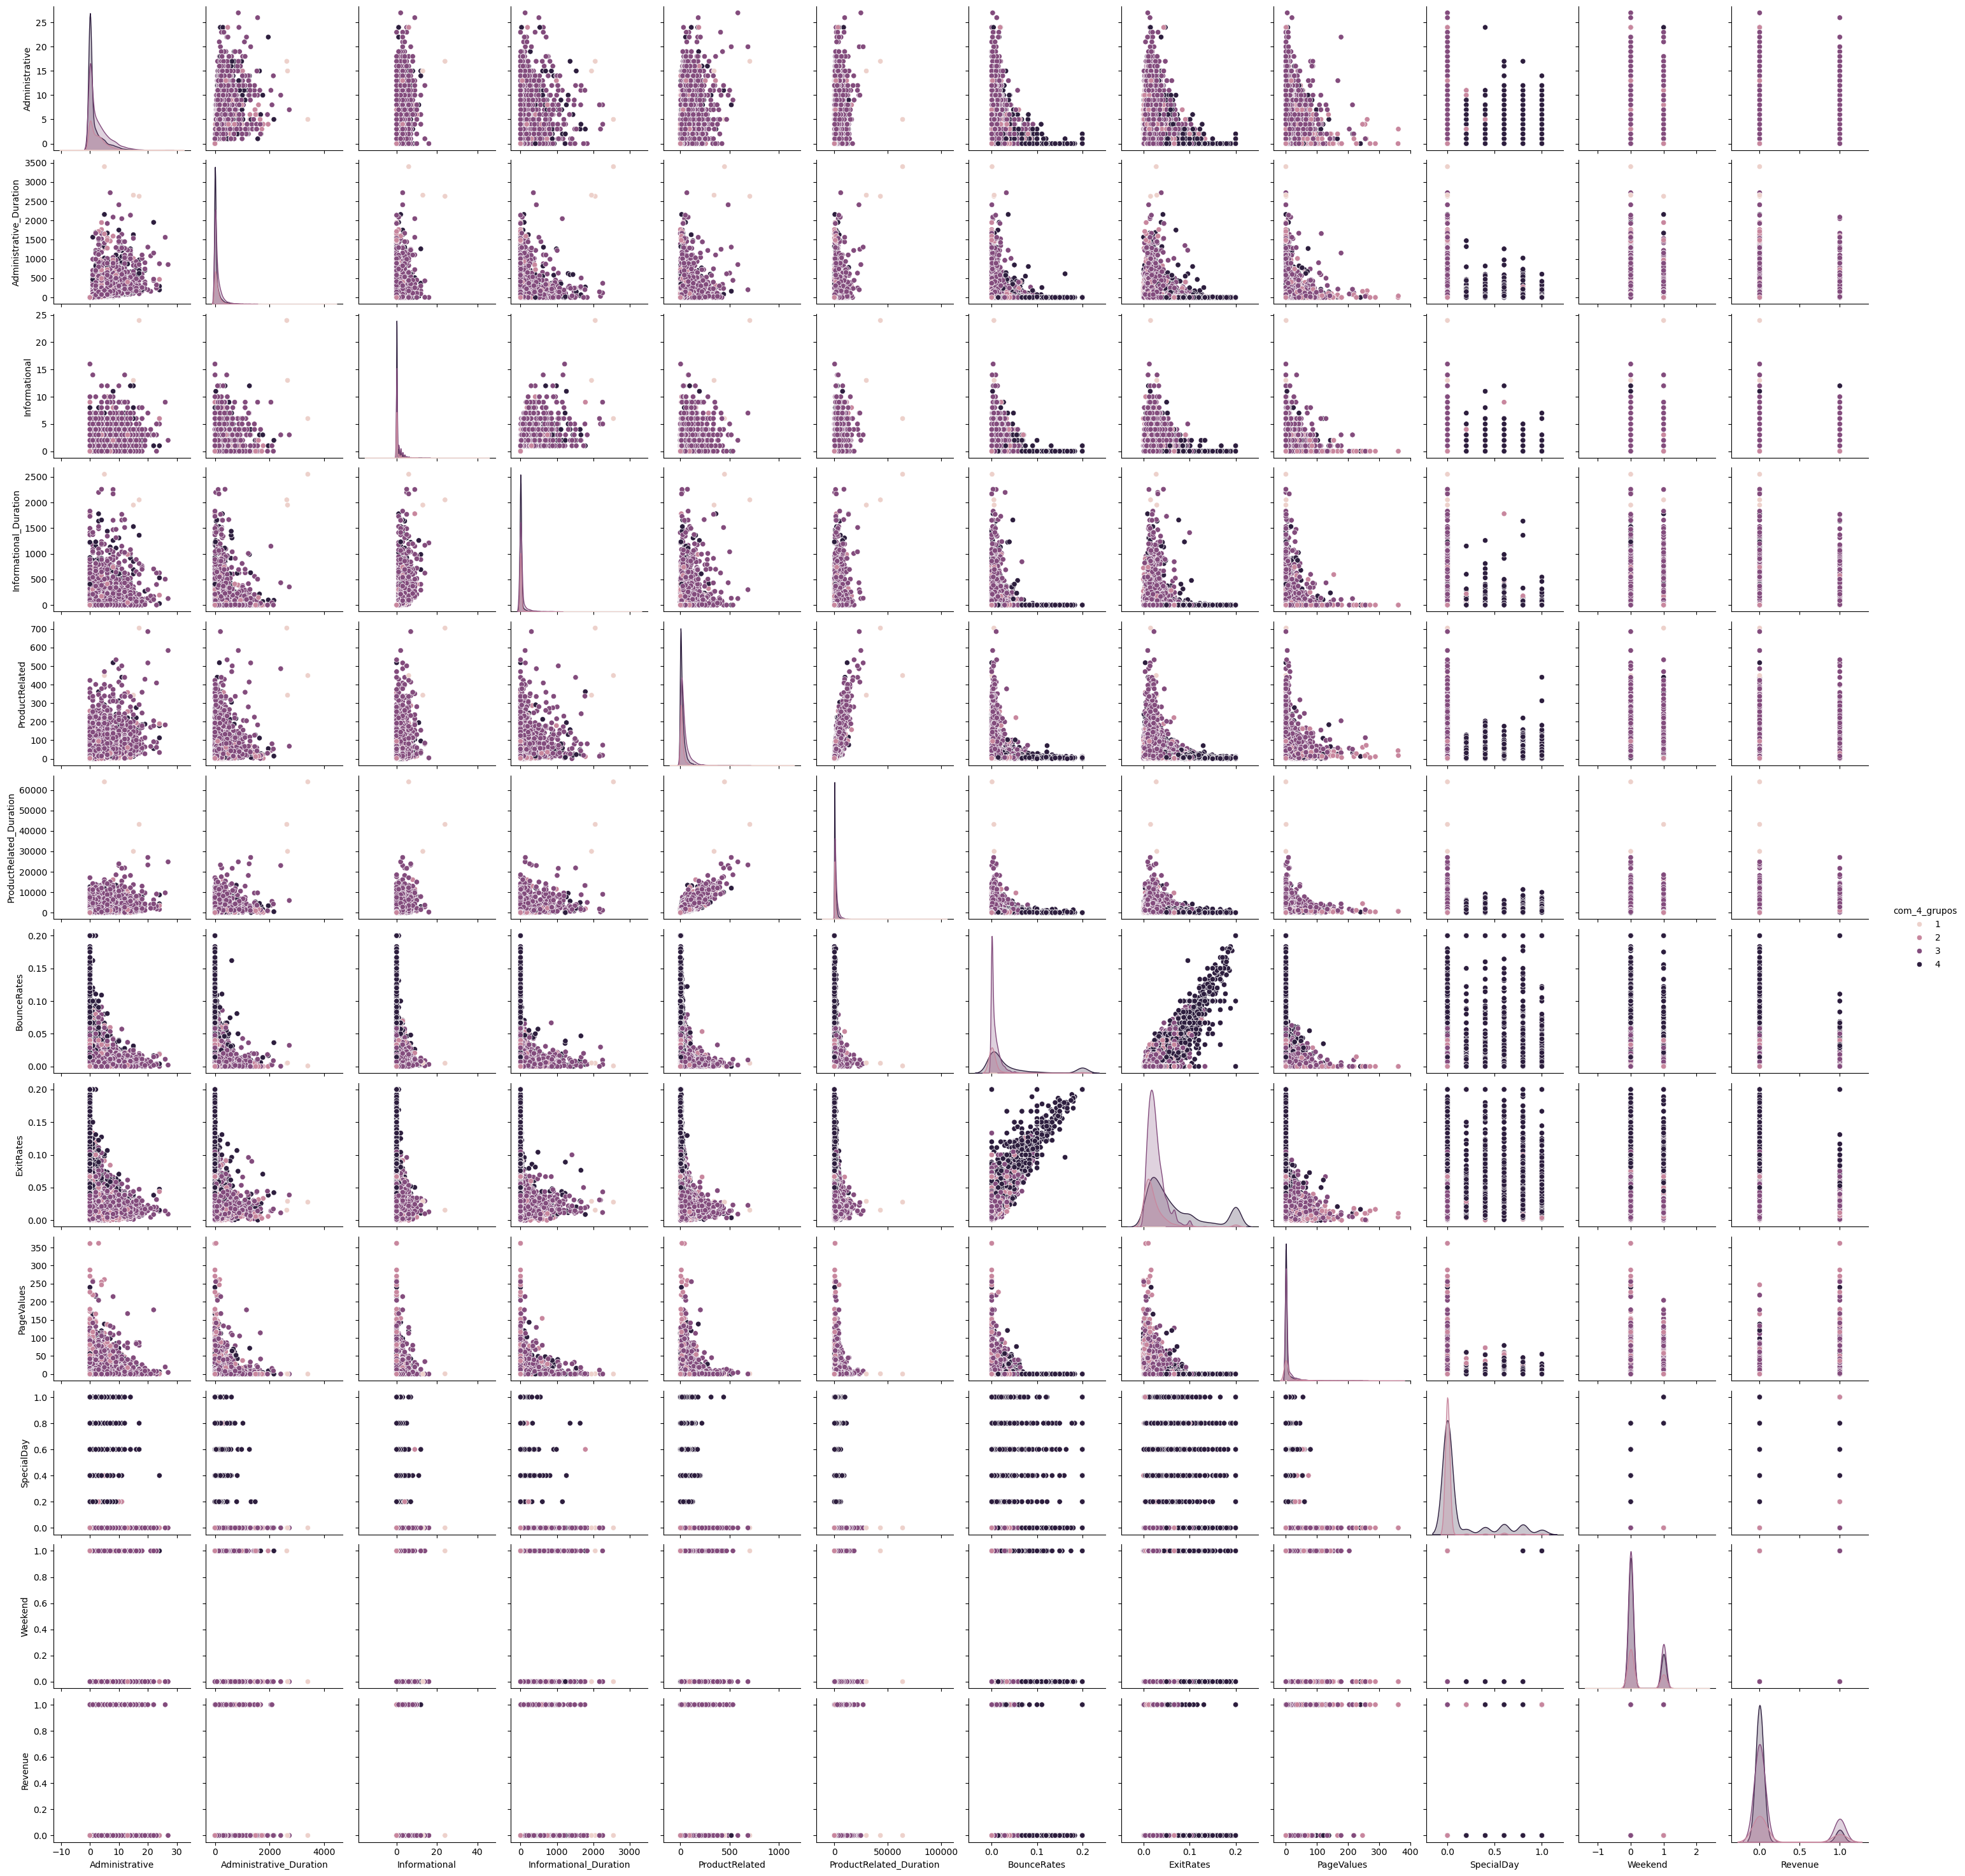

In [67]:
# Com 4 grupos
vars = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'VisitorType', 'Weekend', 'Revenue', 'com_4_grupos']

sns.pairplot(df_group[vars], hue='com_4_grupos')
plt.savefig('paiplot_4_grupos.png', dpi=300)

Revenue        False   True 
com_4_grupos                
1                3.0     0.0
2             1541.0   460.0
3             4439.0  1052.0
4             4439.0   396.0

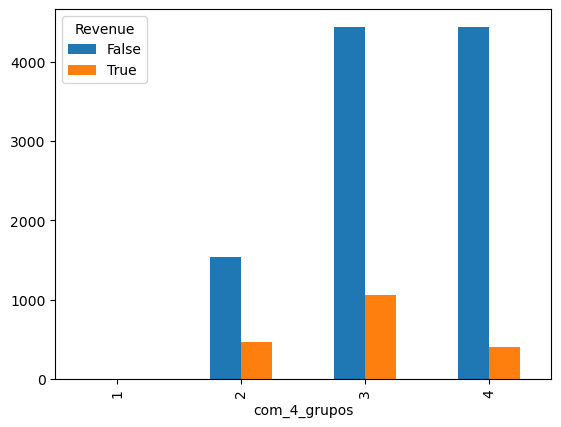

In [68]:
com_4 = df_group.groupby(['com_4_grupos', 'Revenue'])['com_4_grupos'].count().unstack().fillna(0)

#plot
com_4.plot.bar()

com_4

In [69]:
# Tabela cruzada
pd.crosstab(df_group['Revenue'], df_group['com_4_grupos'])

com_4_grupos  1     2     3     4
Revenue                          
False         3  1541  4439  4439
True          0   460  1052   396

In [70]:
# Tabela cruzada com normalização 

pd.crosstab(df_group['Revenue'], df_group['com_4_grupos'], normalize='columns')

com_4_grupos    1         2         3         4
Revenue                                        
False         1.0  0.770115  0.808414  0.918097
True          0.0  0.229885  0.191586  0.081903

O grupo 2 no agrupamento com 3 grupos possui um bom desempenho e parece descrever muito bem o grupo correspondente, uma vez que esse grupo não se altera entre os dois agrupamentos estudados. É notável que o grupo 1, em ambos os agrupamentos, têm uma capacidade excelente para representar dados discrepantes. Talvez fosse uma boa ideia remover tais dados, uma vez que seus valores em `ProductRelated_Duration` destoam bastante em relação às demais observáveis, isso pode ser visto através dos `pairplots` também nos dados abaixo:

In [72]:
df_group[df_group['com_3_grupos'] == 1]

Administrative  Administrative_Duration  Informational  \
5152              17              2629.253968             24   
8071               5              3398.750000              6   
9238              15              2657.318056             13   

      Informational_Duration  ProductRelated  ProductRelated_Duration  \
5152             2050.433333             705              43171.23338   
8071             2549.375000             449              63973.52223   
9238             1949.166667             343              29970.46597   

      BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
5152     0.004851   0.015431    0.763829         0.0   May                 2   
8071     0.000764   0.027701    0.000000         0.0   Dec                 2   
9238     0.005316   0.028971    0.000000         0.0   Dec                 2   

      Browser  Region  TrafficType        VisitorType  Weekend  Revenue  \
5152        2       1           14  Returning_Visitor     True    False   
8071        2       1            2  Returning_Visitor    False    False   
9238        2       1            2  Returning_Visitor    False    False   

      com_3_grupos  com_4_grupos  
5152             1             1  
8071             1             1  
9238             1             1

In [73]:
df_group[df_group['com_4_grupos'] == 1]

Administrative  Administrative_Duration  Informational  \
5152              17              2629.253968             24   
8071               5              3398.750000              6   
9238              15              2657.318056             13   

      Informational_Duration  ProductRelated  ProductRelated_Duration  \
5152             2050.433333             705              43171.23338   
8071             2549.375000             449              63973.52223   
9238             1949.166667             343              29970.46597   

      BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
5152     0.004851   0.015431    0.763829         0.0   May                 2   
8071     0.000764   0.027701    0.000000         0.0   Dec                 2   
9238     0.005316   0.028971    0.000000         0.0   Dec                 2   

      Browser  Region  TrafficType        VisitorType  Weekend  Revenue  \
5152        2       1           14  Returning_Visitor     True    False   
8071        2       1            2  Returning_Visitor    False    False   
9238        2       1            2  Returning_Visitor    False    False   

      com_3_grupos  com_4_grupos  
5152             1             1  
8071             1             1  
9238             1             1

In [74]:
# Note como os três primeiros valores são diferentes dos demais (o grupo 1 os representa)

df_group.sort_values('ProductRelated_Duration', ascending=False).head().style.highlight_max(subset=['ProductRelated_Duration'])

Os `pairplots` também evidenciam essa relação.

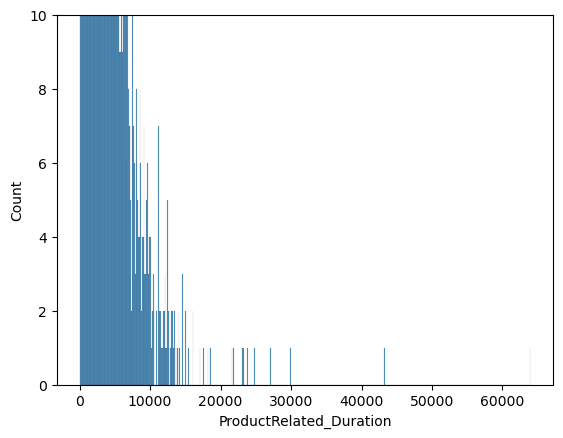

In [76]:
# Visualizando os dados discrepantes
sns.histplot(df_group, x='ProductRelated_Duration')
plt.ylim(0, 10)
plt.show()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

Uma vez que selecionamos o agrupamento com 4 grupos, vamos avaliá-lo

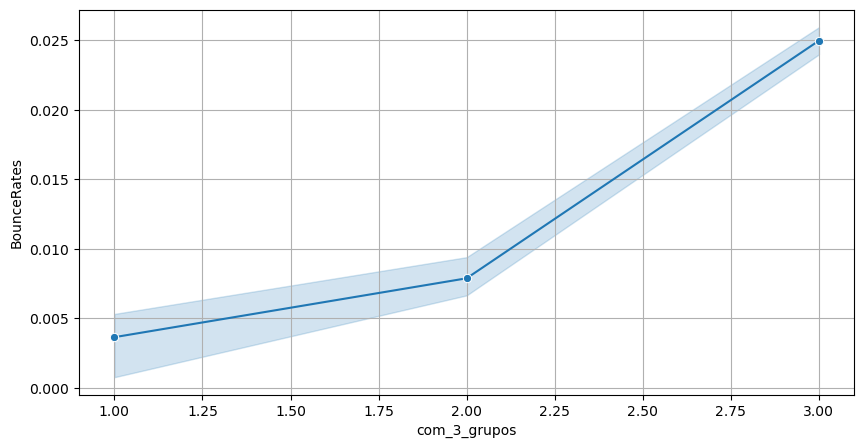

In [79]:
plt.figure(figsize=[10,5])
sns.lineplot(df_group, x='com_3_grupos', y='BounceRates', marker='o')
plt.grid()

<Axes: xlabel='Revenue'>

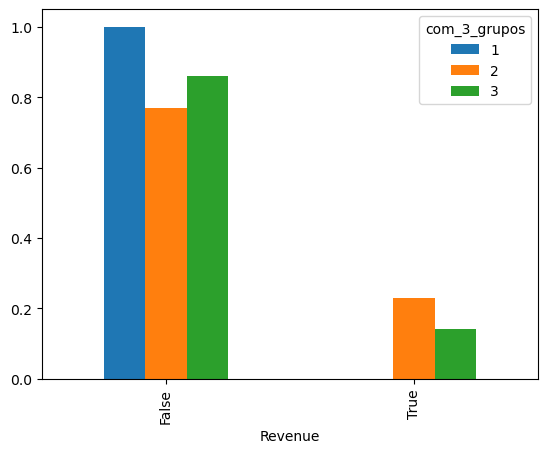

In [80]:
pd.crosstab(df_group.Revenue, df_group['com_3_grupos'], normalize='columns').plot.bar()

In [81]:
pd.crosstab(df_group.Revenue, df_group['com_3_grupos'], normalize='columns')


com_3_grupos    1         2         3
Revenue                              
False         1.0  0.770115  0.859771
True          0.0  0.229885  0.140229

Uma vez que o grupo 1 diz respeito a dados muito específicos, o grupo 2 é o mais propício a finalizar com a compra, uma vez que possui um baixo `BounceRates`, comparado ao grupo 3, e descreve uma porcentagem maior de `Revenue` sendo `True`.